
## Glass Identification Data Set

Downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Glass+Identification)  
The dataset description is as follows:

- Data Set: Multivariate
- Attribute: Real
- Tasks: Classification
- Instances: 214
- Attributes: 10

### Data Set Information:

Vina conducted a comparison test of her rule-based system, BEAGLE, the nearest-neighbor algorithm, and discriminant analysis. BEAGLE is a product available through VRS Consulting, Inc.; 4676 Admiralty Way, Suite 206; Marina Del Ray, CA 90292 (213) 827-7890 and FAX: -3189. In determining whether the glass was a type of "float" glass or not, the following results were obtained (# incorrect answers): 

Type of Sample -- Beagle -- NN -- DA 
Windows that were float processed (87) -- 10 -- 12 -- 21 
Windows that were not: (76) -- 19 -- 16 -- 22 

The study of classification of types of glass was motivated by criminological investigation. At the scene of the crime, the glass left can be used as evidence...if it is correctly identified!.

### Attribute Information:

To construct the data, seven geometric parameters of wheat kernels were measured:

1. Id number: 1 to 214 
2. RI: refractive index 
3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10) 
4. Mg: Magnesium 
5. Al: Aluminum 
6. Si: Silicon 
7. K: Potassium 
8. Ca: Calcium 
9. Ba: Barium 
10. Fe: Iron 
11. Type of glass: (class attribute) 
-- 1 building_windows_float_processed 
-- 2 building_windows_non_float_processed 
-- 3 vehicle_windows_float_processed 
-- 4 vehicle_windows_non_float_processed (none in this database) 
-- 5 containers 
-- 6 tableware 
-- 7 headlamps



#### Correctly identifying glass at a crime scene can provide evidence to be used in solving the crime.

The dataset can be divided into window glass (type 1-4) and non-window glass (type 5-7). T

1: (type 1-4) window glass 163,

2: (type 5-7)non-window glass 51,

In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests

import numpy as np
import pandas as pd
import seaborn as sns

from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt


#Ignore warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"

def fetch_data(fname='glass_dataset.txt'):
    """
    Helper method to retreive the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Fetch the data if required
DATA = fetch_data()

In [3]:
FEATURES  = [
    "Id",
    "RI",
    "Na",
    "Mg",
    "Al",
    "Si",
    "K",
    "Ca",
    "Ba",
    "Fe",
    "Typeofglass"
]

LABEL_MAP = {
    1: "type 1",
    2: "type 2",
    3: "type 3",
    4: "type 4",
    5: "type 5",
    6: "type 6",
    7: "type 7",
}
    

# Read the data into a DataFrame
df = pd.read_csv(DATA, sep=',', header=None, names=FEATURES)

#Drop Id Column
df.drop("Id",axis=1,inplace=True)

# Convert class labels into text
df['Typeofglass'] = df['Typeofglass'].map(LABEL_MAP)
                 
# Describe the dataset
print(df.describe())                 

               RI          Na          Mg          Al          Si           K  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516523   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

               Ca          Ba          Fe  
count  214.000000  214.000000  214.000000  
mean     8.956963    0.175047    0.057009  
std      1.423153    0.497219    0.097439  
min      5.430000    0.000000    0.000000  
25%      8.240000    0.000000    0.000000  
50%   

We can see that there are no missing data because the "count" for each attribute is 214

In [4]:
# Determine the shape of the data
print("{} instances with {} features\n".format(*df.shape))

# Determine the frequency of each class
print(df.groupby('Typeofglass')['Typeofglass'].count())

214 instances with 10 features

Typeofglass
type 1    70
type 2    76
type 3    17
type 5    13
type 6     9
type 7    29
Name: Typeofglass, dtype: int64


There are 214 observations in the dataset and the number of observations in each type is imbalanced. Note that there are no examples for type 4 (non-float processed vehicle windows) in the dataset

We're going to create a binary classification problem by dividing the glass type into two groups. Glass type 1-4 are classified as "window glass"(class = 0) and glass type 5-7 are classied as "non-window glass"(class = 1)

In [5]:
#changing target variable to binary using replcae function
df['Typeofglass'] = df['Typeofglass'].replace(['type 1','type 2','type 3','type 4'], 0) # window glass
df['Typeofglass'] = df['Typeofglass'].replace(['type 5','type 6','type 7'], 1) #non-window glass

In [6]:
# Determine the frequency of each class
print(df.groupby('Typeofglass')['Typeofglass'].count())

Typeofglass
0    163
1     51
Name: Typeofglass, dtype: int64


We see that there are 163 instances of window glass (class = 0) and 51 instances of non-window glass (class = 1). This tells us class imbalance may be an issue because there are far more instances of window glass than non-window glass. We've learned that most machine learning algorithms work best when the number of instances of each classes are roughly equal.

#### Here we're using LabelEncoder to encode the "Typeofglass" variable with a value between 0 and 1

In [7]:
from sklearn.preprocessing import LabelEncoder

# Extract our X and y data
X = df[FEATURES[1:]]
y = df['Typeofglass']

# Encode our target variable
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)

print(X.shape, y.shape)

(214, 10) (214,)


#### We're using Pandas and Yellowbrick to create various visualizations of our data to help us better undrestand how our features interact with eachother.

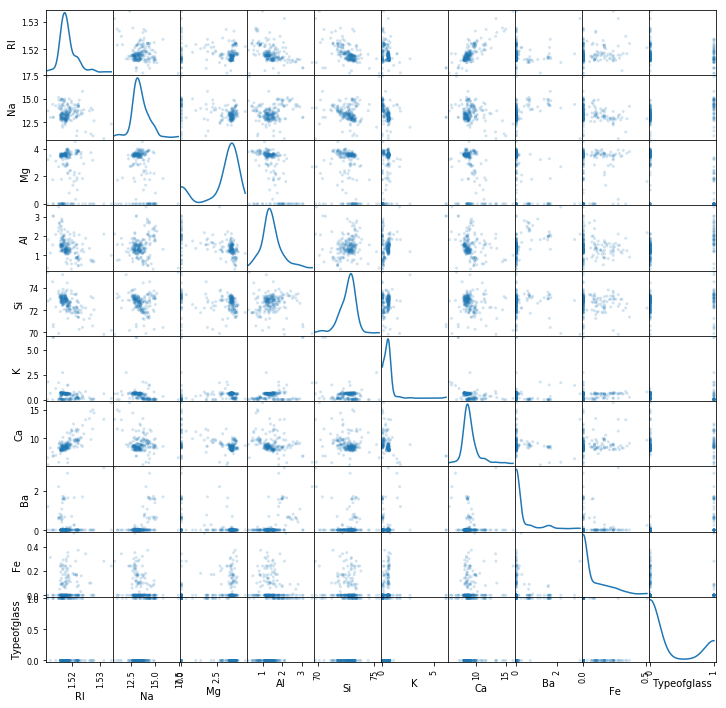

In [8]:
# Create a scatter matrix of the dataframe features
from pandas.plotting import scatter_matrix
scatter_matrix(X, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

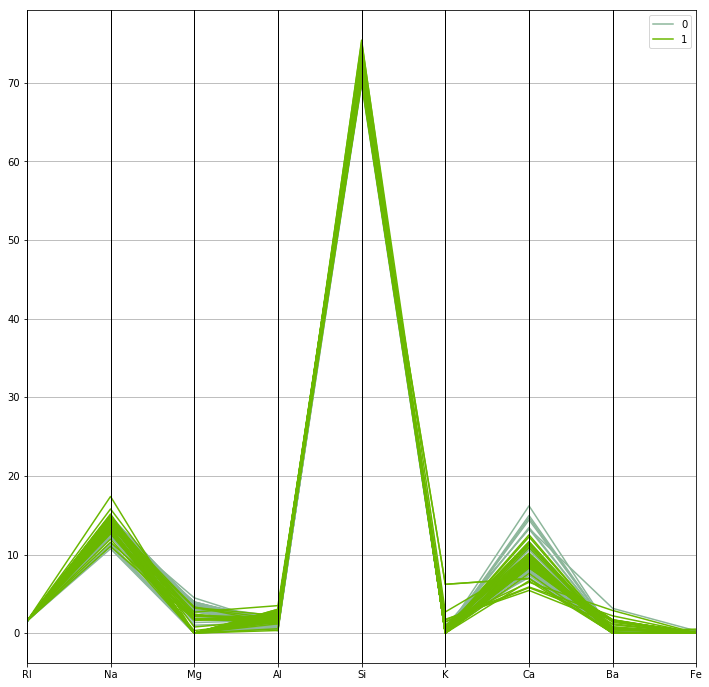

In [9]:
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(12,12))
parallel_coordinates(df, 'Typeofglass')
plt.show()

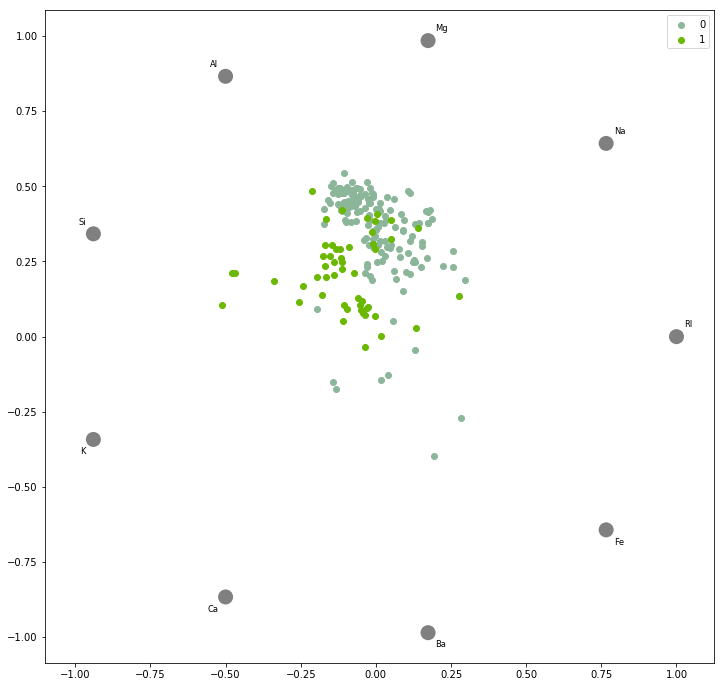

In [10]:
df.head()
from pandas.plotting import radviz
plt.figure(figsize=(12,12))
radviz(df, 'Typeofglass')
plt.show()

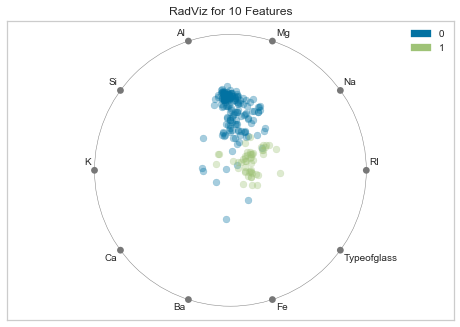

In [11]:
from yellowbrick.features import RadViz

_ = RadViz(classes=encoder.classes_, alpha=0.35).fit_transform_poof(X, y)

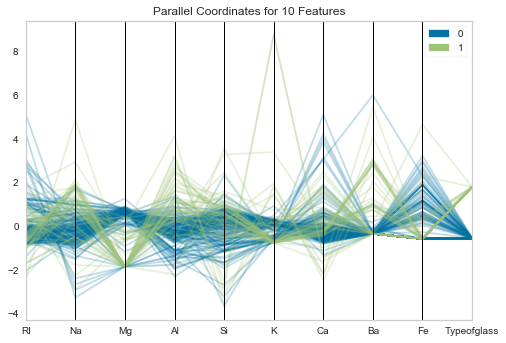

In [12]:
from yellowbrick.features import ParallelCoordinates

_ = ParallelCoordinates(classes=encoder.classes_, normalize='standard').fit_transform_poof(X, y)

## Data Extraction 

In order to manage our data set on disk, we'll structure our data as follows:

In [13]:
from sklearn.datasets.base import Bunch

DATA_DIR = os.path.abspath(os.path.join(".", "..", "ML_glassdataset"))
print("DATA_DIR:" + str(DATA_DIR))
# Show the contents of the data directory
for name in os.listdir(DATA_DIR):
    if name.startswith("."): continue
    print("- {}".format(name))

DATA_DIR:/Users/tamananaheeme/Desktop/GU_DS/ML_glassdataset
- glass-identification-random-forest-classifier.pickle
- glass_dataset.txt
- uciml_glass_identification-example.ipynb
- multinomial-naive-bayes.pickle
- glass-identificatio-knn-classifier.pickle
- uci_ml_glassdata-example.ipynb
- README.md
- glass-knn-classifier.pickle
- glass-random-forest-classifier.pickle
- glass-identification-logistic-regression.pickle
- ML_Glass_Identification.ipynb
- ML_Glass_Identification-Copy1.ipynb
- glass-svc-classifier.pickle
- glass-logistic-regression.pickle
- ML_Glass_Identification-method.ipynb
- meta.json


In [14]:
def load_data(root=DATA_DIR):
    # Construct the `Bunch` for the glass dataset
    filenames     = {
        'meta': os.path.join(root, 'meta.json'),
        'rdme': os.path.join(root, 'README.md'),
        'data': os.path.join(root, 'glass_dataset.txt'),
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
    dataset = np.loadtxt(filenames['data'], delimiter=",")

    # Extract the target from the data
    data   = dataset[:, 1:-1]
    target = dataset[:, -1]

    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print(dataset.data.shape)
print(dataset.target.shape)

(214, 9)
(214,)


## Classification 

Now that we have a dataset `Bunch` loaded and ready, we can begin the classification process. Let's attempt to build a classifier with kNN, SVM, LogisticReg, naive bayes, and Random Forest classifiers. 

In [15]:
from sklearn import metrics

from sklearn.model_selection import KFold
from yellowbrick.model_selection import ValidationCurve

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ClassificationReport

In [16]:
def fit_and_evaluate(dataset, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    kf = KFold(n_splits = 12, shuffle=True)
    
    for train, test in kf.split(dataset.data):
        X_train, X_test = dataset.data[train], dataset.data[test]
        y_train, y_test = dataset.target[train], dataset.target[test]
        
        estimator = model(**kwargs)
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(dataset.data, dataset.target)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)
    
    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [25]:
# Perform kNN Classification
fit_and_evaluate(dataset, KNeighborsClassifier, "Glass kNN Classifier", n_neighbors=12)

Build and Validation of Glass kNN Classifier took 0.032 seconds
Validation scores are as follows:

precision    0.608552
recall       0.602124
accuracy     0.602124
f1           0.572740
dtype: float64

Fitted model written to:
/Users/tamananaheeme/Desktop/GU_DS/ML_glassdataset/glass-knn-classifier.pickle


In [26]:
# Perform Multinomial Naive Bayes
fit_and_evaluate(dataset, MultinomialNB, "Multinomial Naive Bayes")

Build and Validation of Multinomial Naive Bayes took 0.030 seconds
Validation scores are as follows:

precision    0.470267
recall       0.462418
accuracy     0.462418
f1           0.413554
dtype: float64

Fitted model written to:
/Users/tamananaheeme/Desktop/GU_DS/ML_glassdataset/multinomial-naive-bayes.pickle


In [27]:
# Perform Random Forest Classification
fit_and_evaluate(dataset, RandomForestClassifier, "Glass Random Forest Classifier")

Build and Validation of Glass Random Forest Classifier took 0.118 seconds
Validation scores are as follows:

precision    0.808643
recall       0.766885
accuracy     0.766885
f1           0.764614
dtype: float64

Fitted model written to:
/Users/tamananaheeme/Desktop/GU_DS/ML_glassdataset/glass-random-forest-classifier.pickle


In [28]:
# Perform Logistic Regression
fit_and_evaluate(dataset, LogisticRegression, "Glass Logistic Regression")

Build and Validation of Glass Logistic Regression took 0.051 seconds
Validation scores are as follows:

precision    0.554160
recall       0.611383
accuracy     0.611383
f1           0.568533
dtype: float64

Fitted model written to:
/Users/tamananaheeme/Desktop/GU_DS/ML_glassdataset/glass-logistic-regression.pickle


In [29]:
# Perform SVC Classification
fit_and_evaluate(dataset, SVC, "Glass SVC Classifier", gamma = 'auto')

Build and Validation of Glass SVC Classifier took 0.046 seconds
Validation scores are as follows:

precision    0.638965
recall       0.659314
accuracy     0.659314
f1           0.628189
dtype: float64

Fitted model written to:
/Users/tamananaheeme/Desktop/GU_DS/ML_glassdataset/glass-svc-classifier.pickle


#### Based on the initial scores, Random Forest perfom best

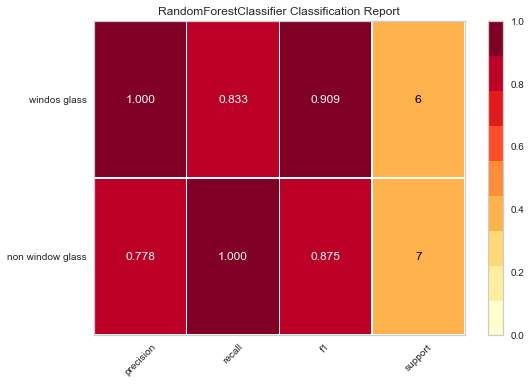

In [30]:
#generating classification report for Random Forest

# Specify the target classes
classes = ["non window glass","windos glass"]

# Create the training and test data
kf = KFold(n_splits = 12, shuffle=True)

for train, test in kf.split(dataset.data):
        X_train, X_test = dataset.data[train], dataset.data[test]
        y_train, y_test = dataset.target[train], dataset.target[test]

# Instantiate the classification model and visualizer
model = RandomForestClassifier()
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof()                       # Finalize and show the figure       
                

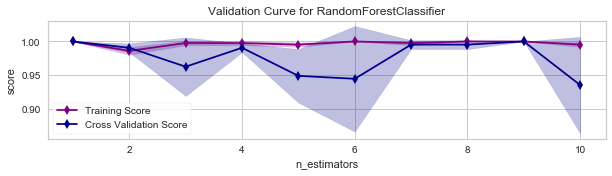

In [31]:
# hyperparameter tuning validation curve 

mpl.rcParams['axes.prop_cycle'] = cycler('color', ['purple', 'darkblue'])

fig = plt.gcf()
fig.set_size_inches(10,10)
ax = plt.subplot(411)

viz = ValidationCurve(RandomForestClassifier(), param_name="n_estimators", param_range=np.arange(1, 11), cv=3, scoring="accuracy")

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

In [35]:
# Perform Random Forest Classification
fit_and_evaluate(dataset, RandomForestClassifier, "Glass Random Forest Classifier",n_estimators=7 )

Build and Validation of Glass Random Forest Classifier took 0.092 seconds
Validation scores are as follows:

precision    0.776863
recall       0.751906
accuracy     0.751906
f1           0.742290
dtype: float64

Fitted model written to:
/Users/tamananaheeme/Desktop/GU_DS/ML_glassdataset/glass-random-forest-classifier.pickle
